# Spectrum offset of different slices
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven)
Creation date: October 4th 2018 

This notebook computes the pixel offset of the SWP filter transmission, seen by the MRS, in the different IFU slices.

### > Import modules

In [1]:
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [2]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"
FilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

### > Give analysis inputs

In [3]:
# inputs
band = '4C'                     # spectral band under investigation
ref_slice = 6                  # reference slice
ref_alpha = 0.                  # along-slice position, [arcsec]

### > Import MRS observations

<IPython.core.display.Javascript object>


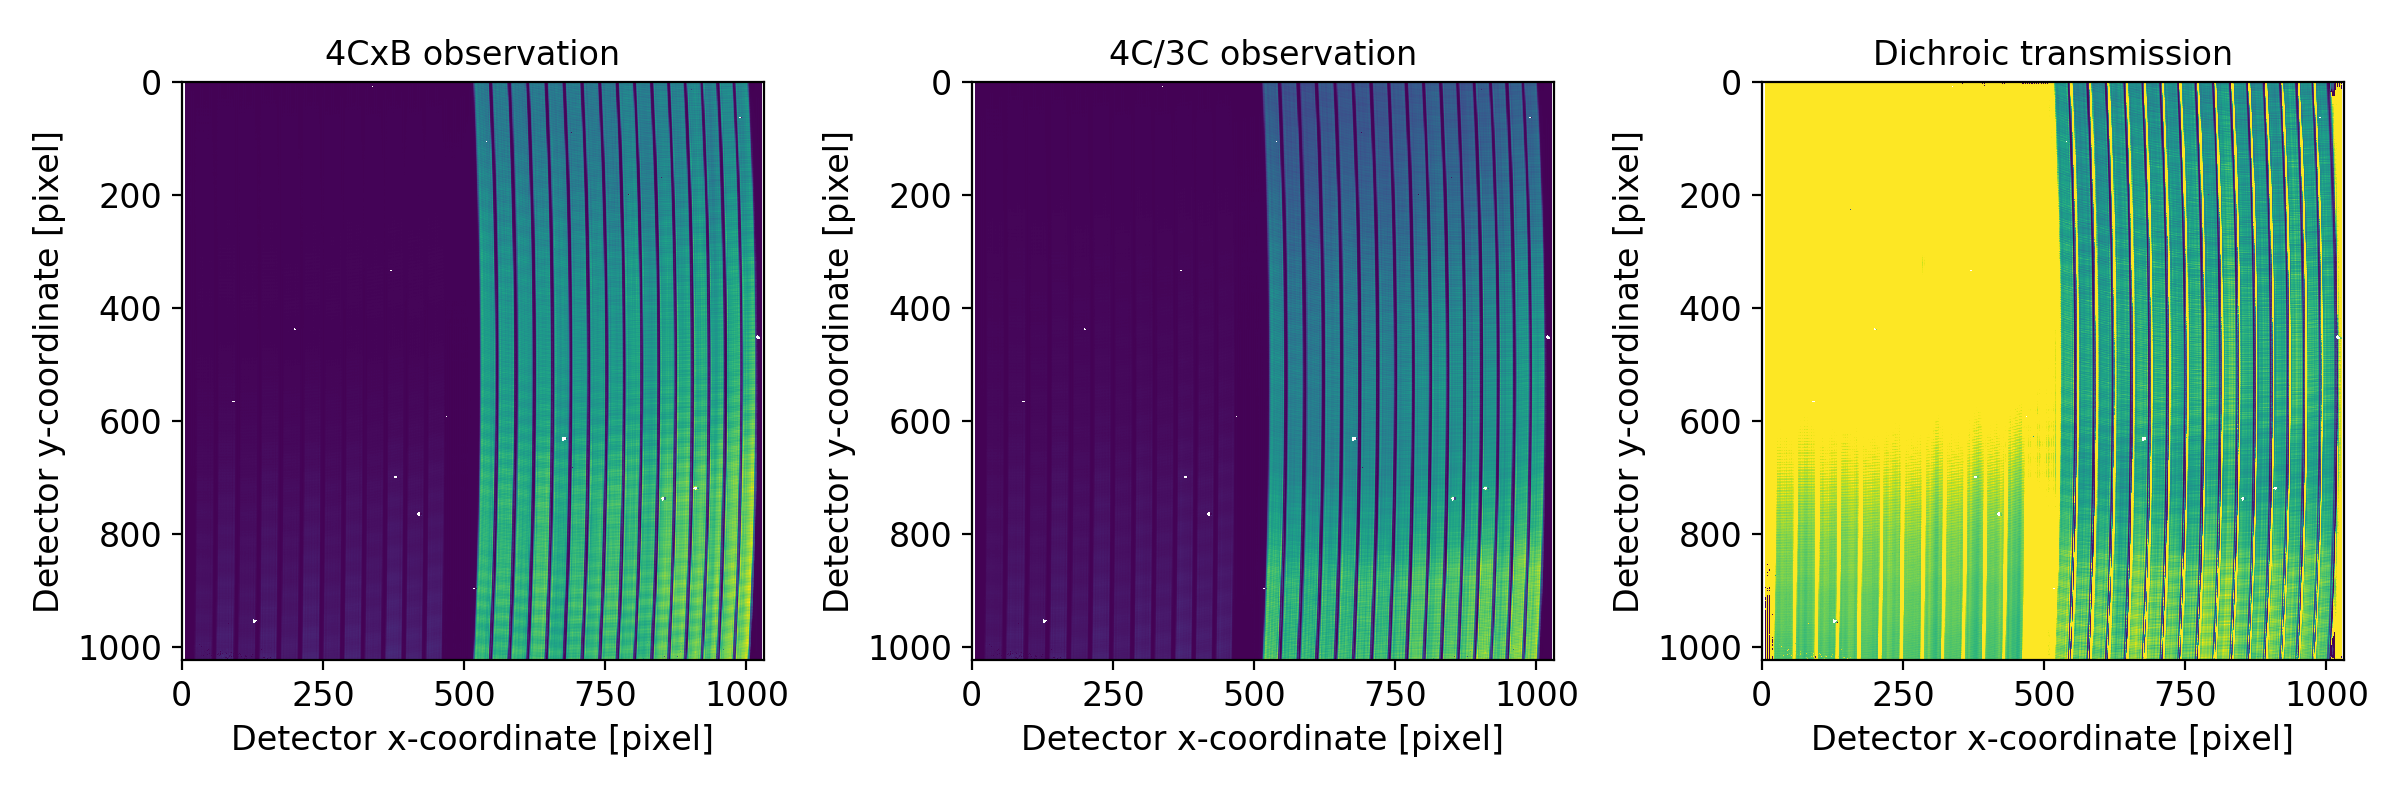

In [5]:
usedfilter,source_img1,source_img2,mrs_transmission_img = funcs.mrs_filter_transmission(band,datapath=lvl2path)

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(source_img1)
axs[1].imshow(source_img2)
axs[2].imshow(mrs_transmission_img,vmin=0,vmax=1.4)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
if usedfilter in ['SWP','LWP']:
    axs[0].set_title('{} filter observation'.format(usedfilter),fontsize=12)
    axs[1].set_title('Extended source observation',fontsize=12)
    axs[2].set_title('{} filter transmission'.format(usedfilter),fontsize=12)
if band == '2A':
    axs[0].set_title('2AxB observation',fontsize=12)
    axs[1].set_title('1A/2A observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
elif band == '4C':
    axs[0].set_title('4CxB observation',fontsize=12)
    axs[1].set_title('4C/3C observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
plt.tight_layout()

### > Determine spectrum offset between the central trace of each MRS IFU slice

In [6]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

<IPython.core.display.Javascript object>


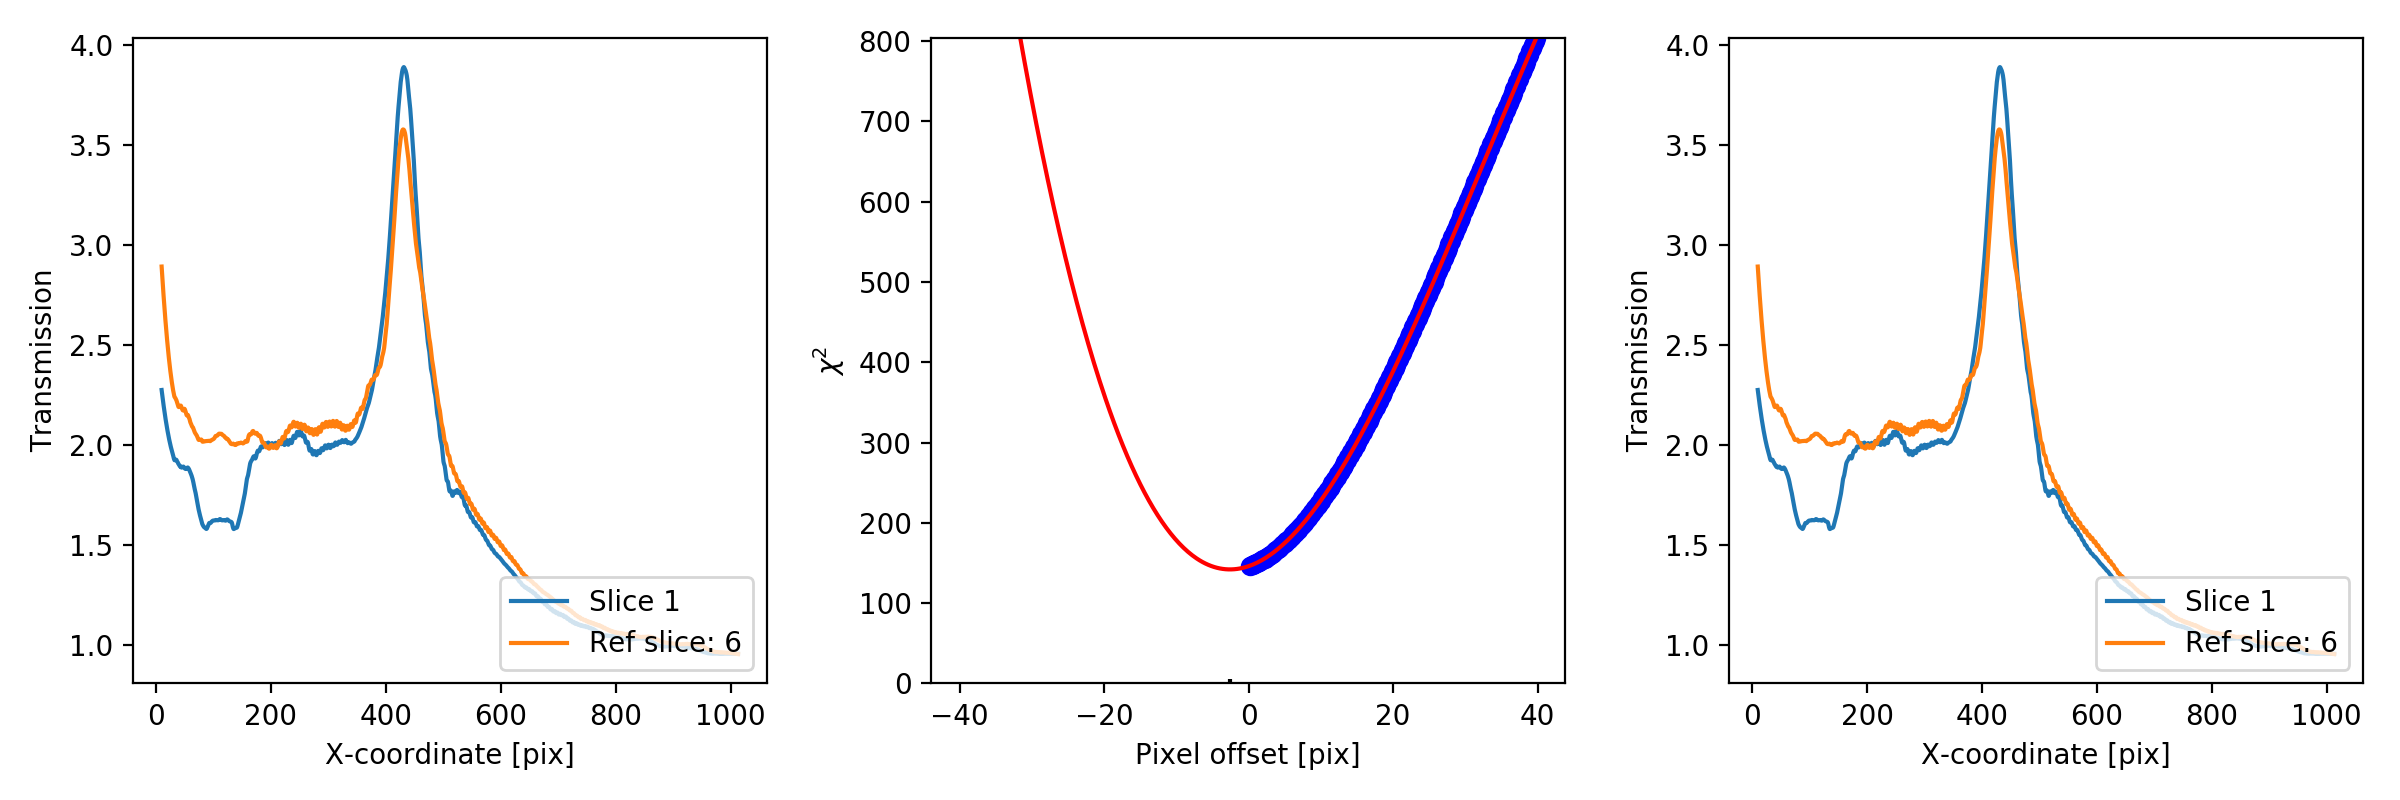

Slice 1
Pixel offset: -2.6pix


<IPython.core.display.Javascript object>


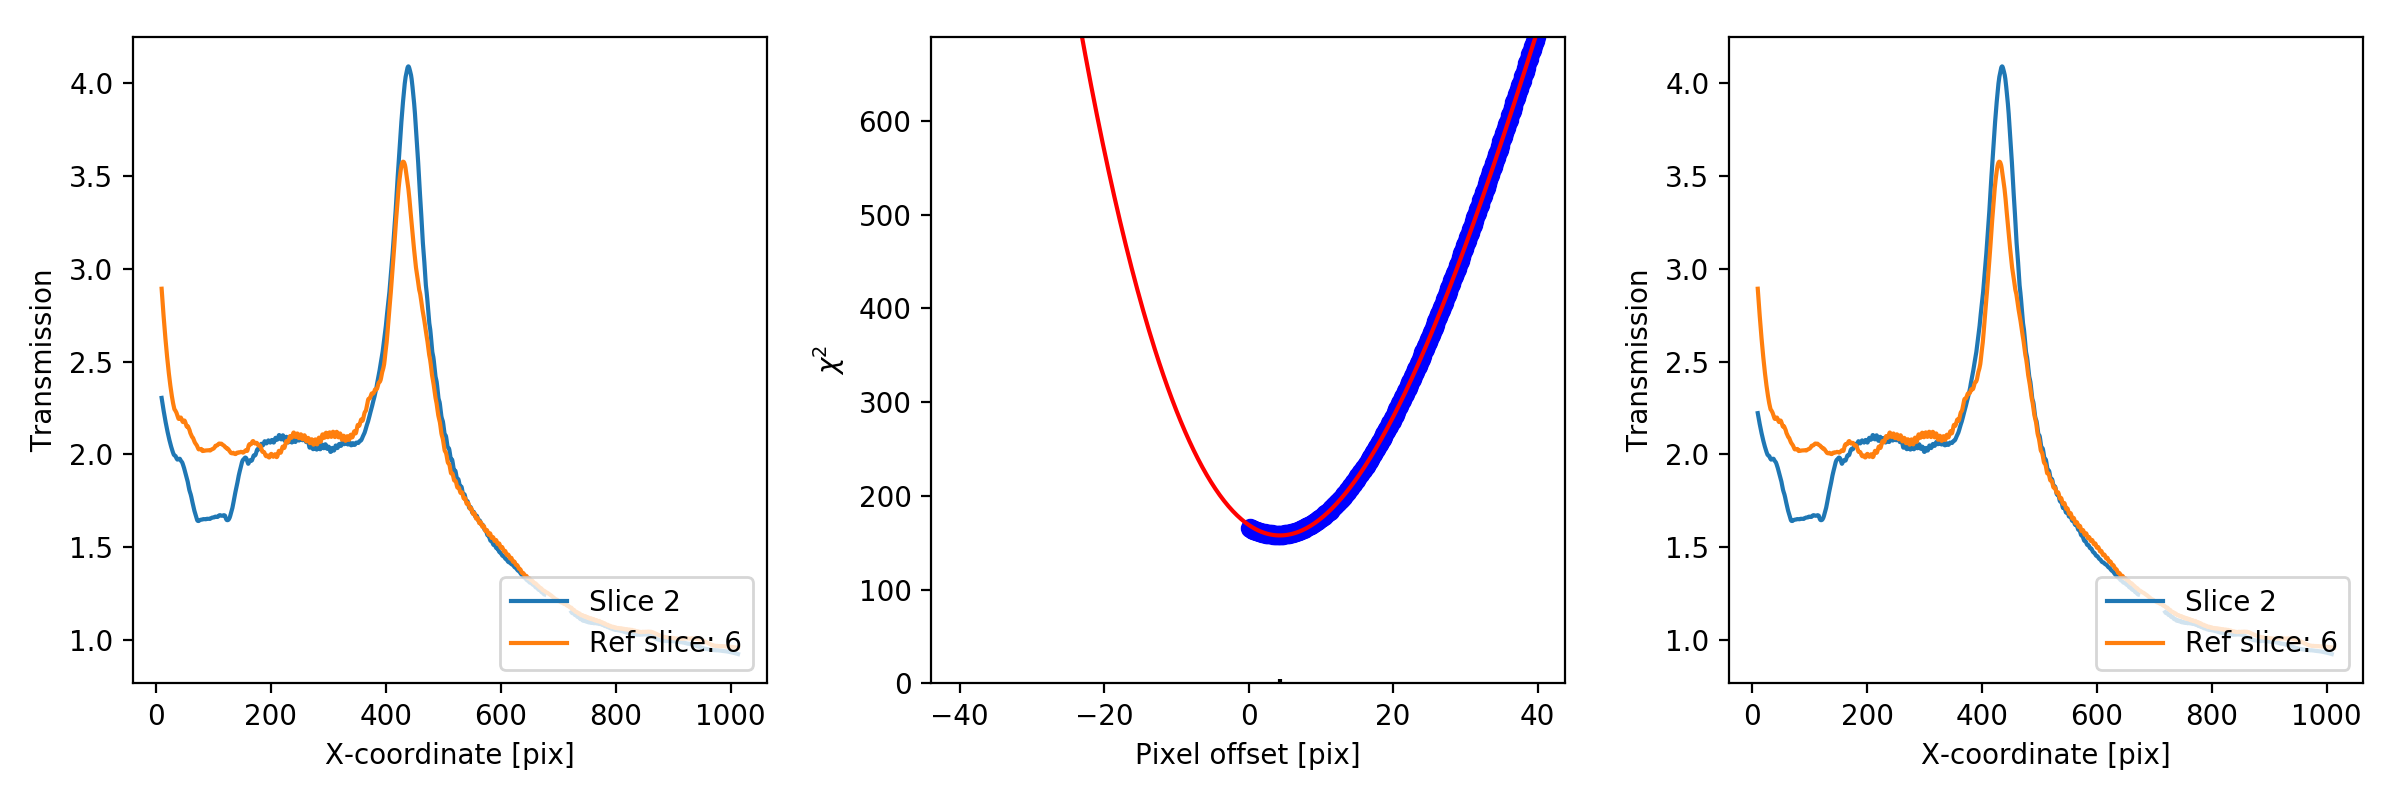

Slice 2
Pixel offset: 4.4pix


<IPython.core.display.Javascript object>


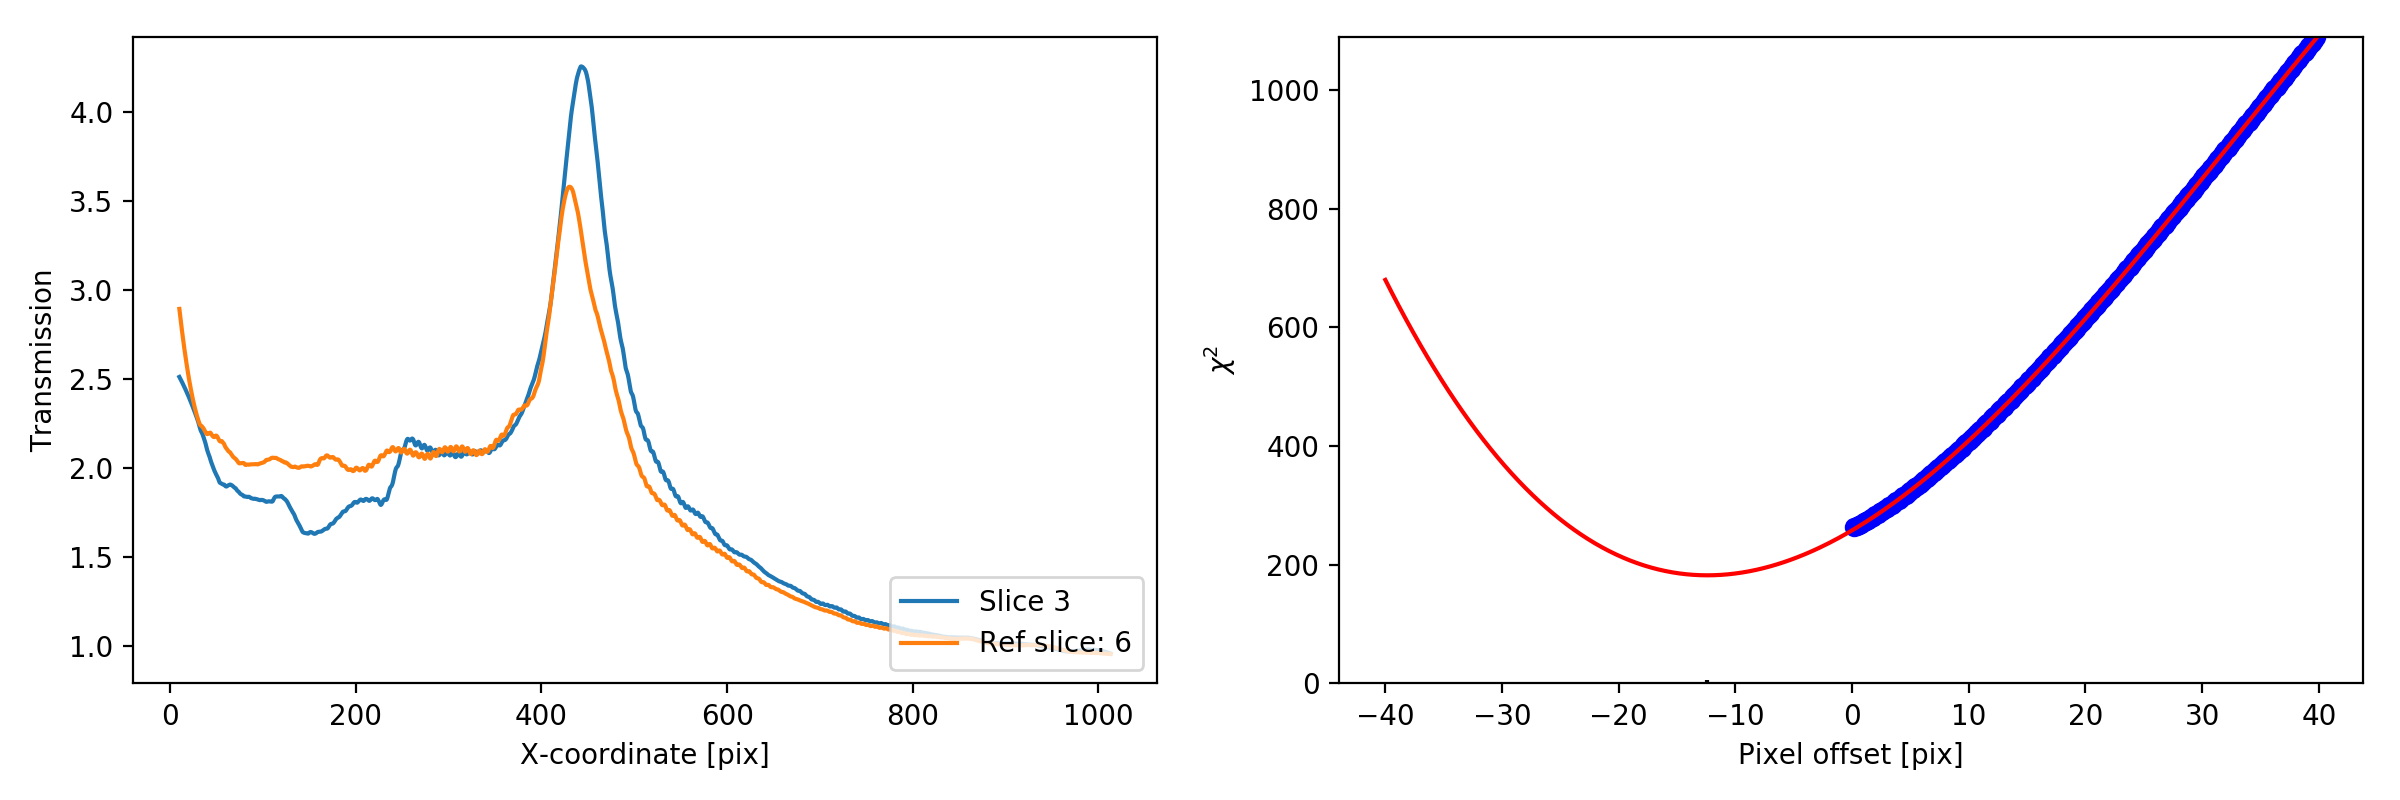

Slice 3
Pixel offset: -12.4pix


<IPython.core.display.Javascript object>


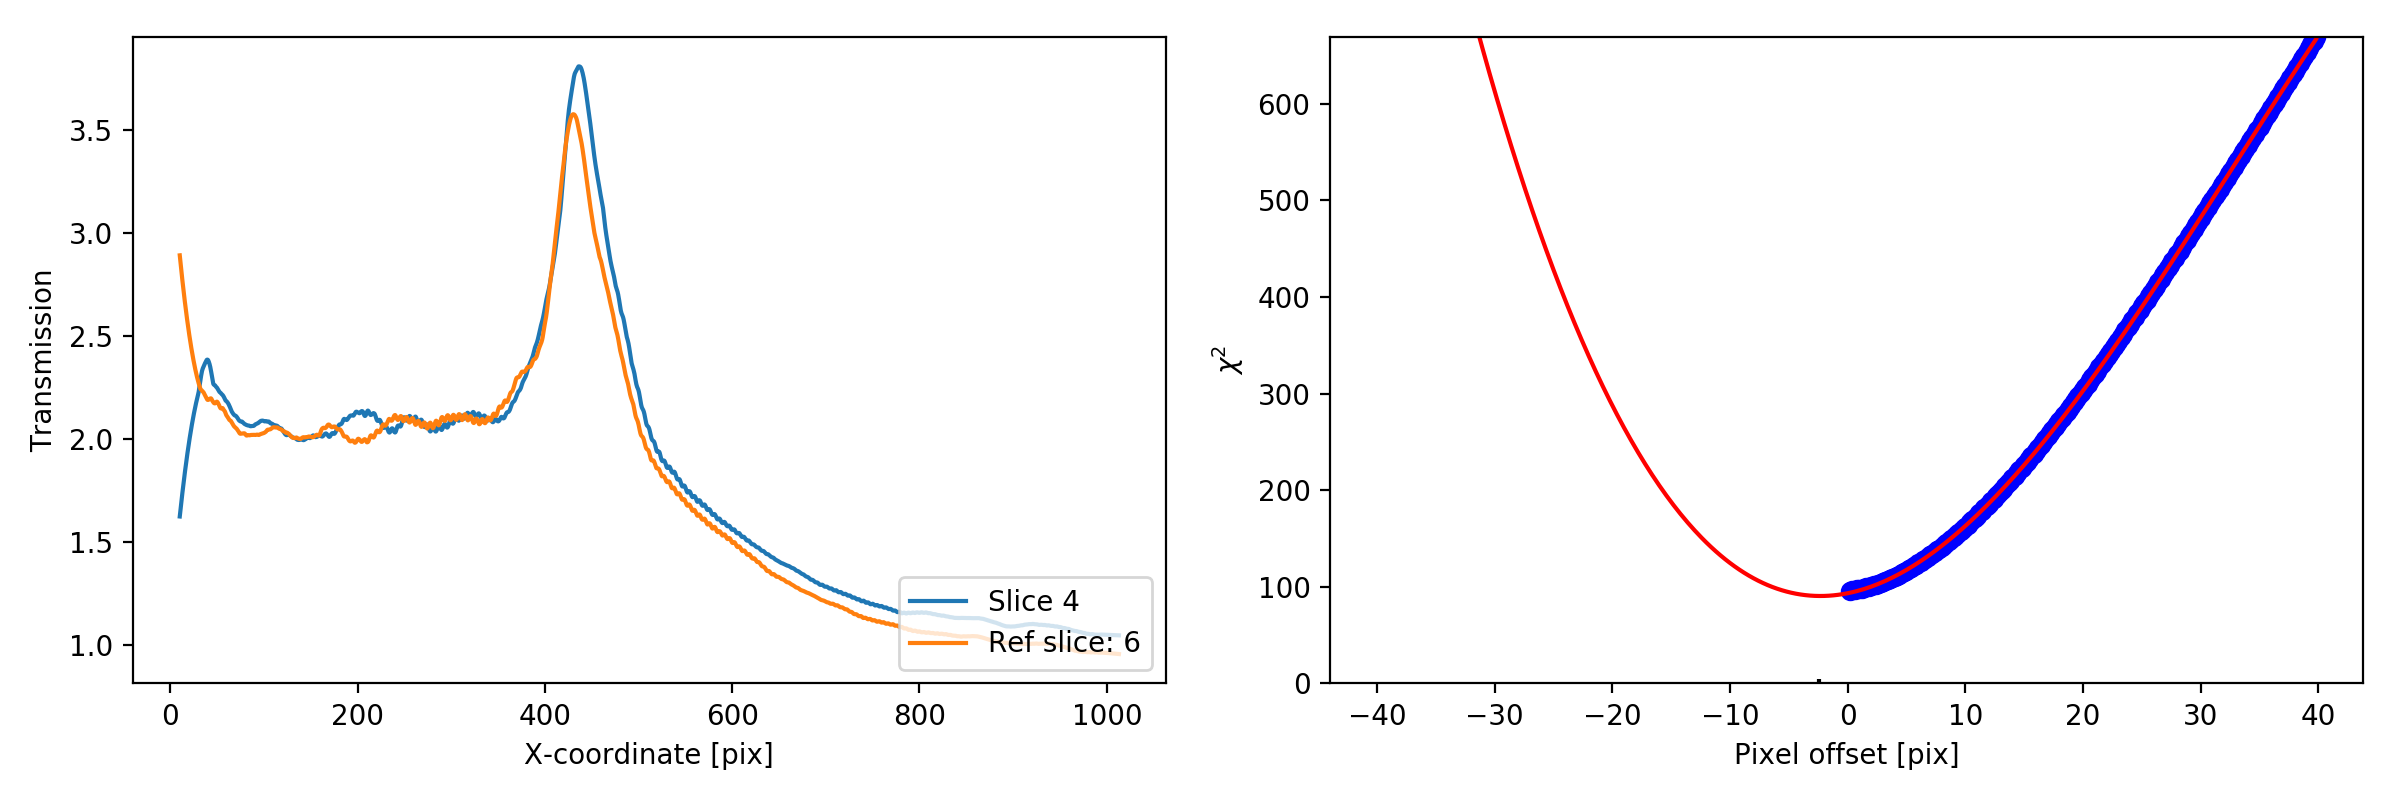

Slice 4
Pixel offset: -2.4pix


<IPython.core.display.Javascript object>


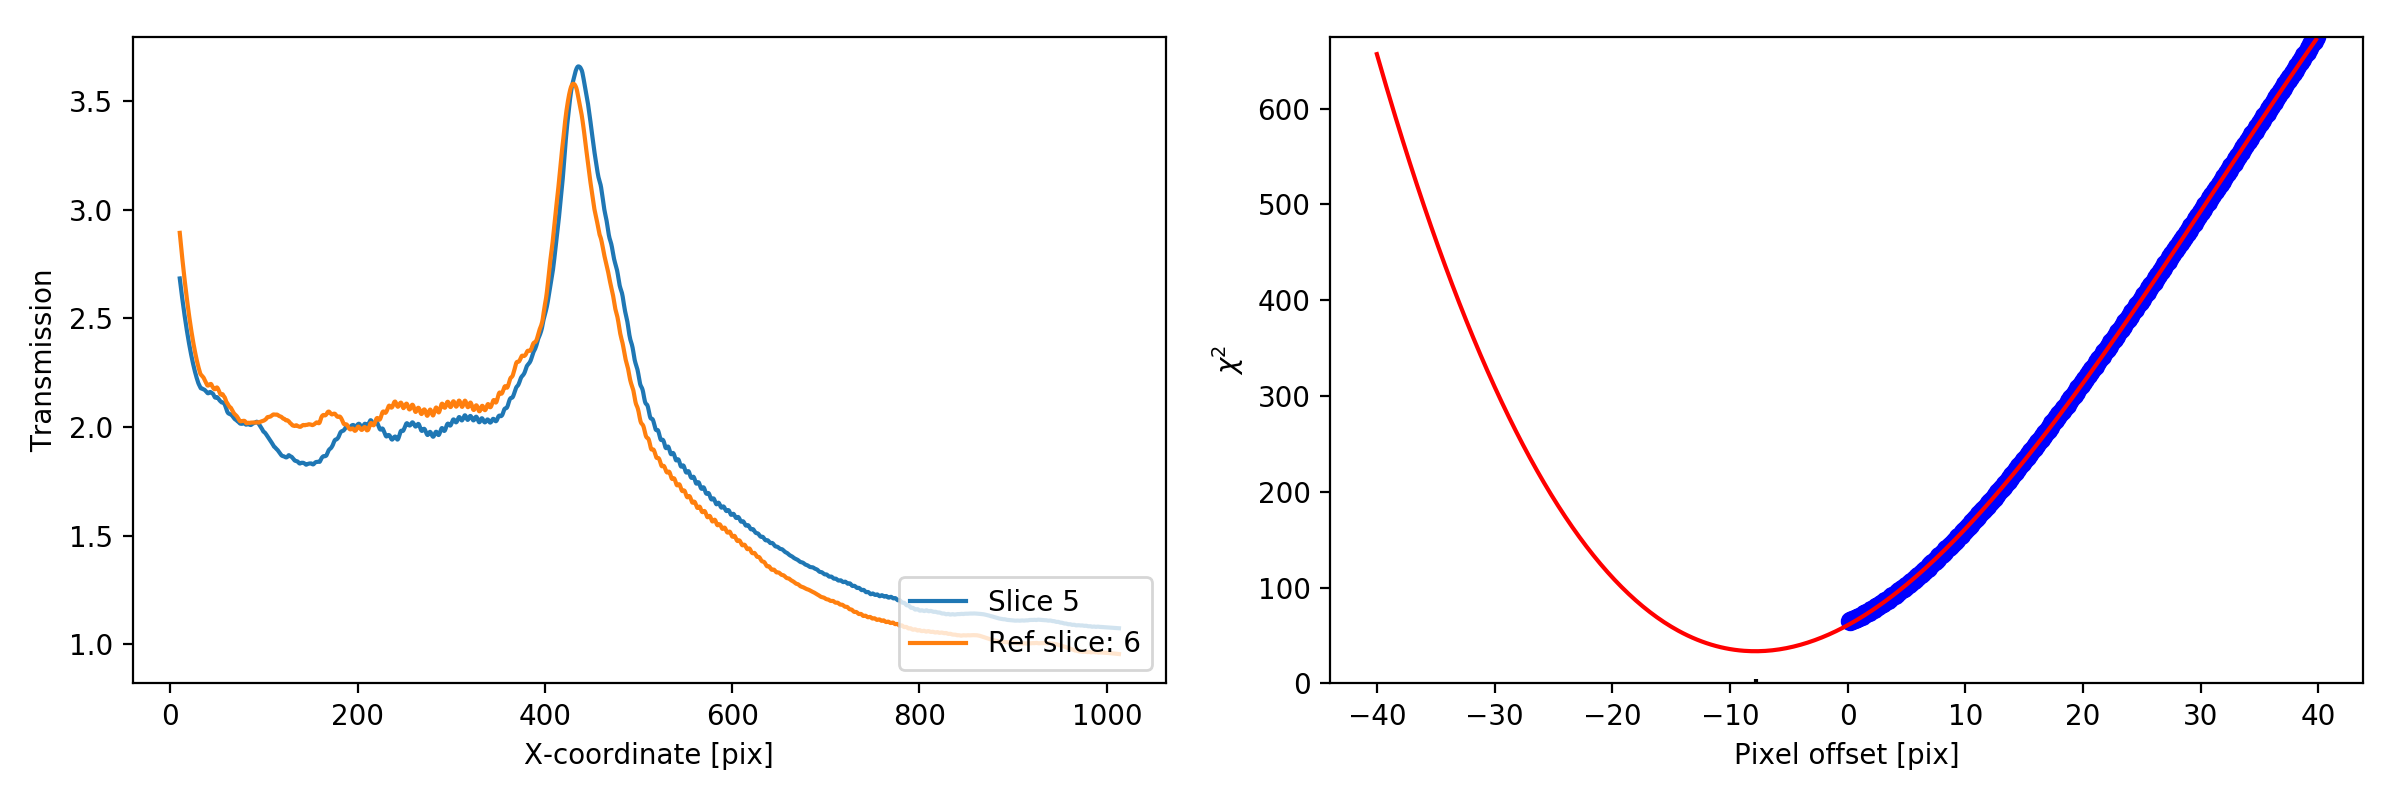

Slice 5
Pixel offset: -7.8pix
Slice 6
Pixel offset: -7.8pix


<IPython.core.display.Javascript object>


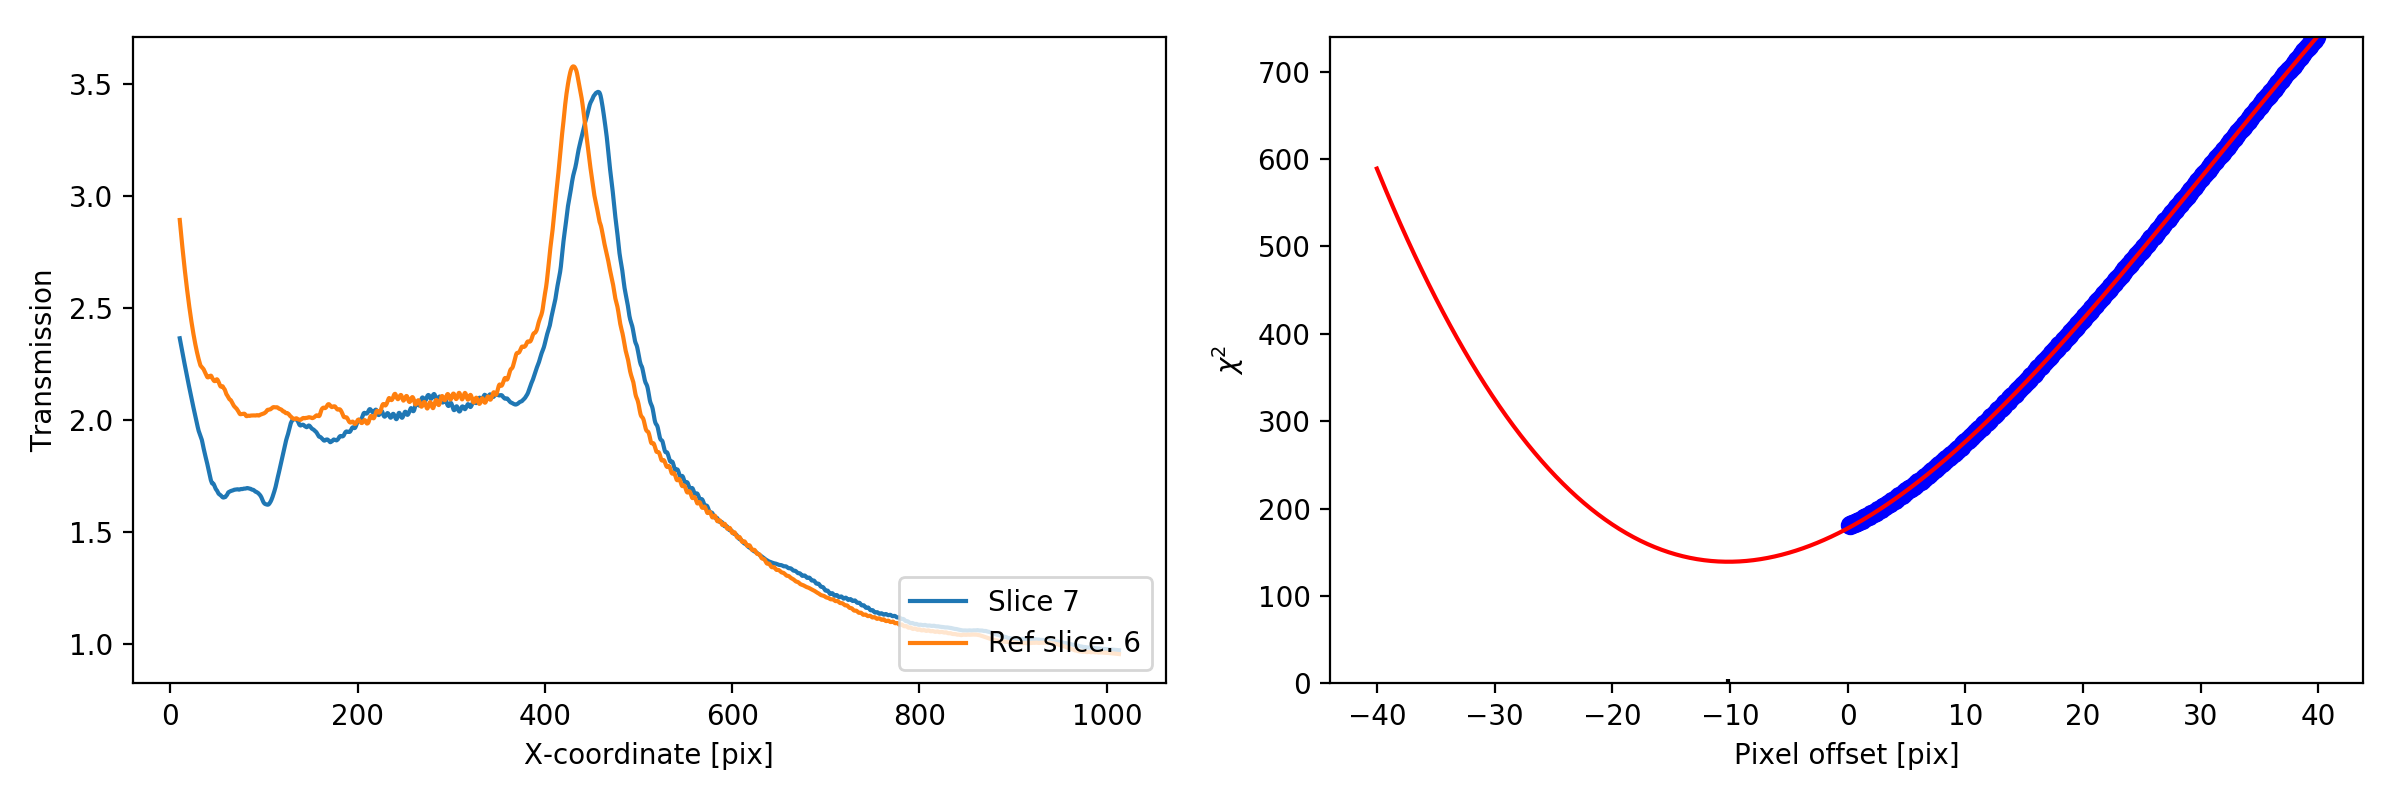

Slice 7
Pixel offset: -10.2pix


<IPython.core.display.Javascript object>


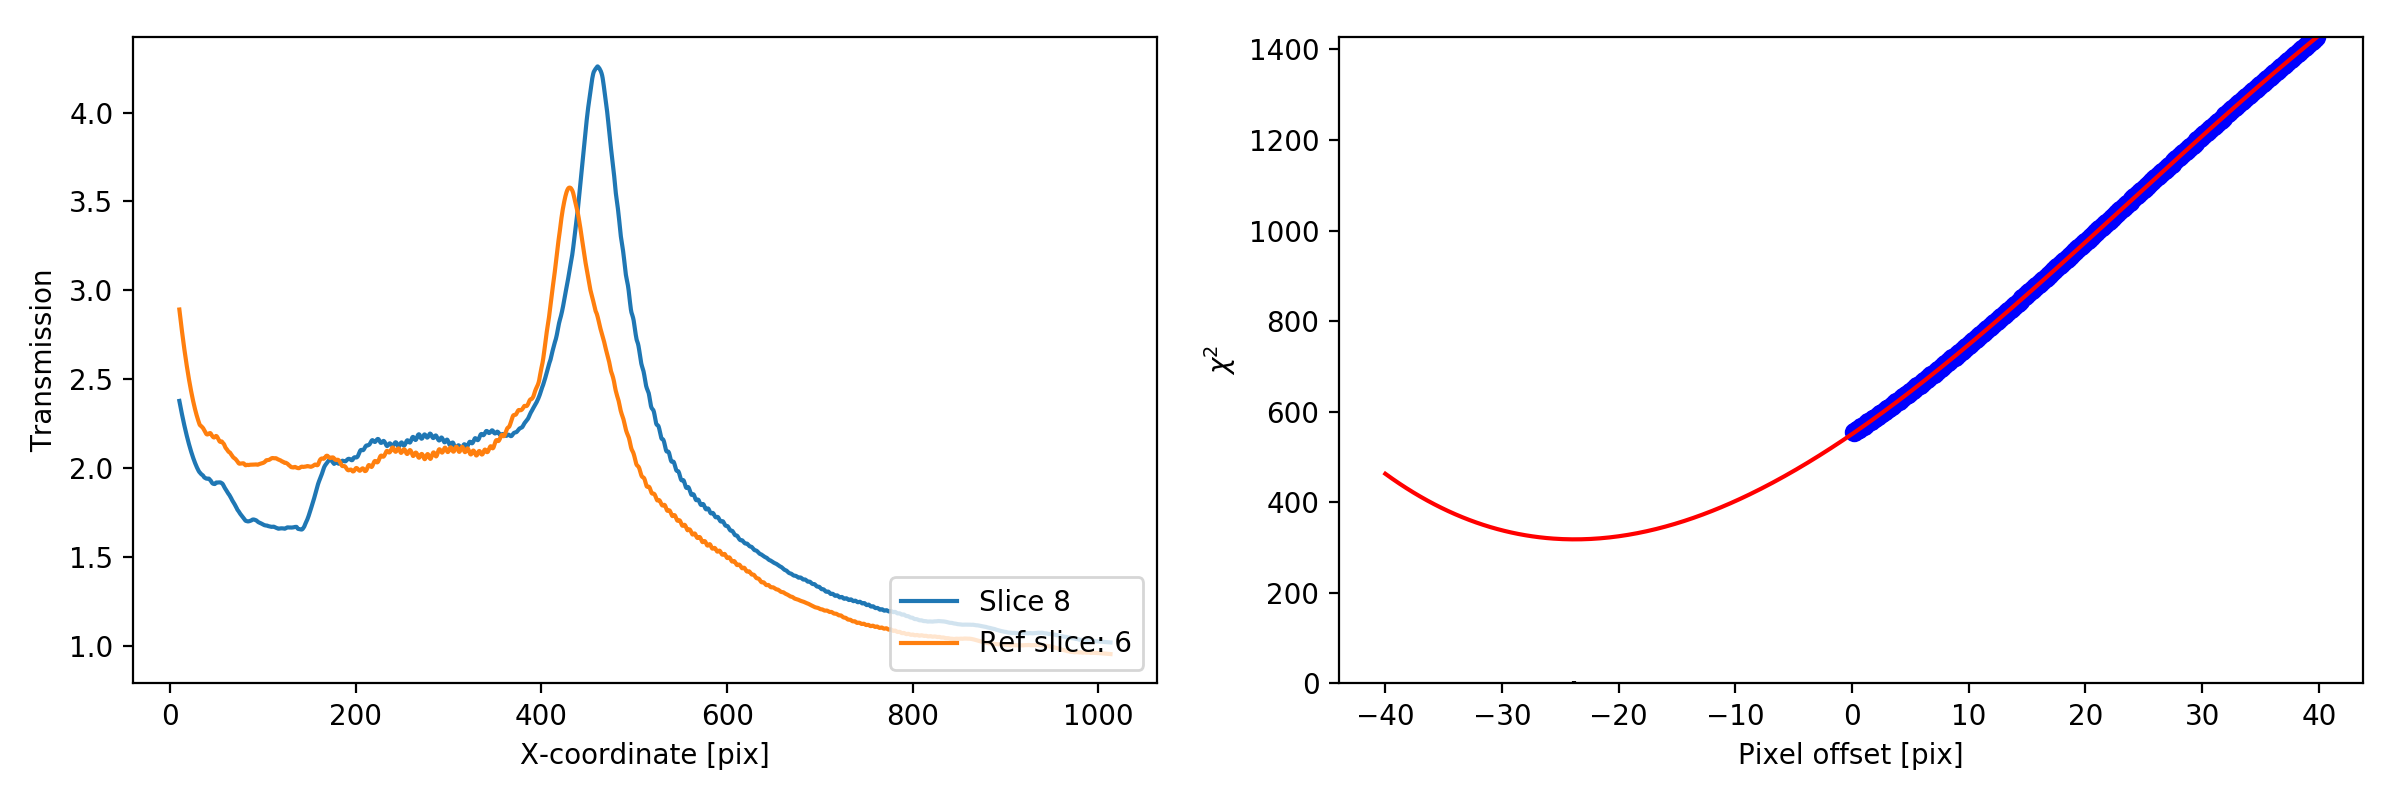

Slice 8
Pixel offset: -23.8pix


<IPython.core.display.Javascript object>


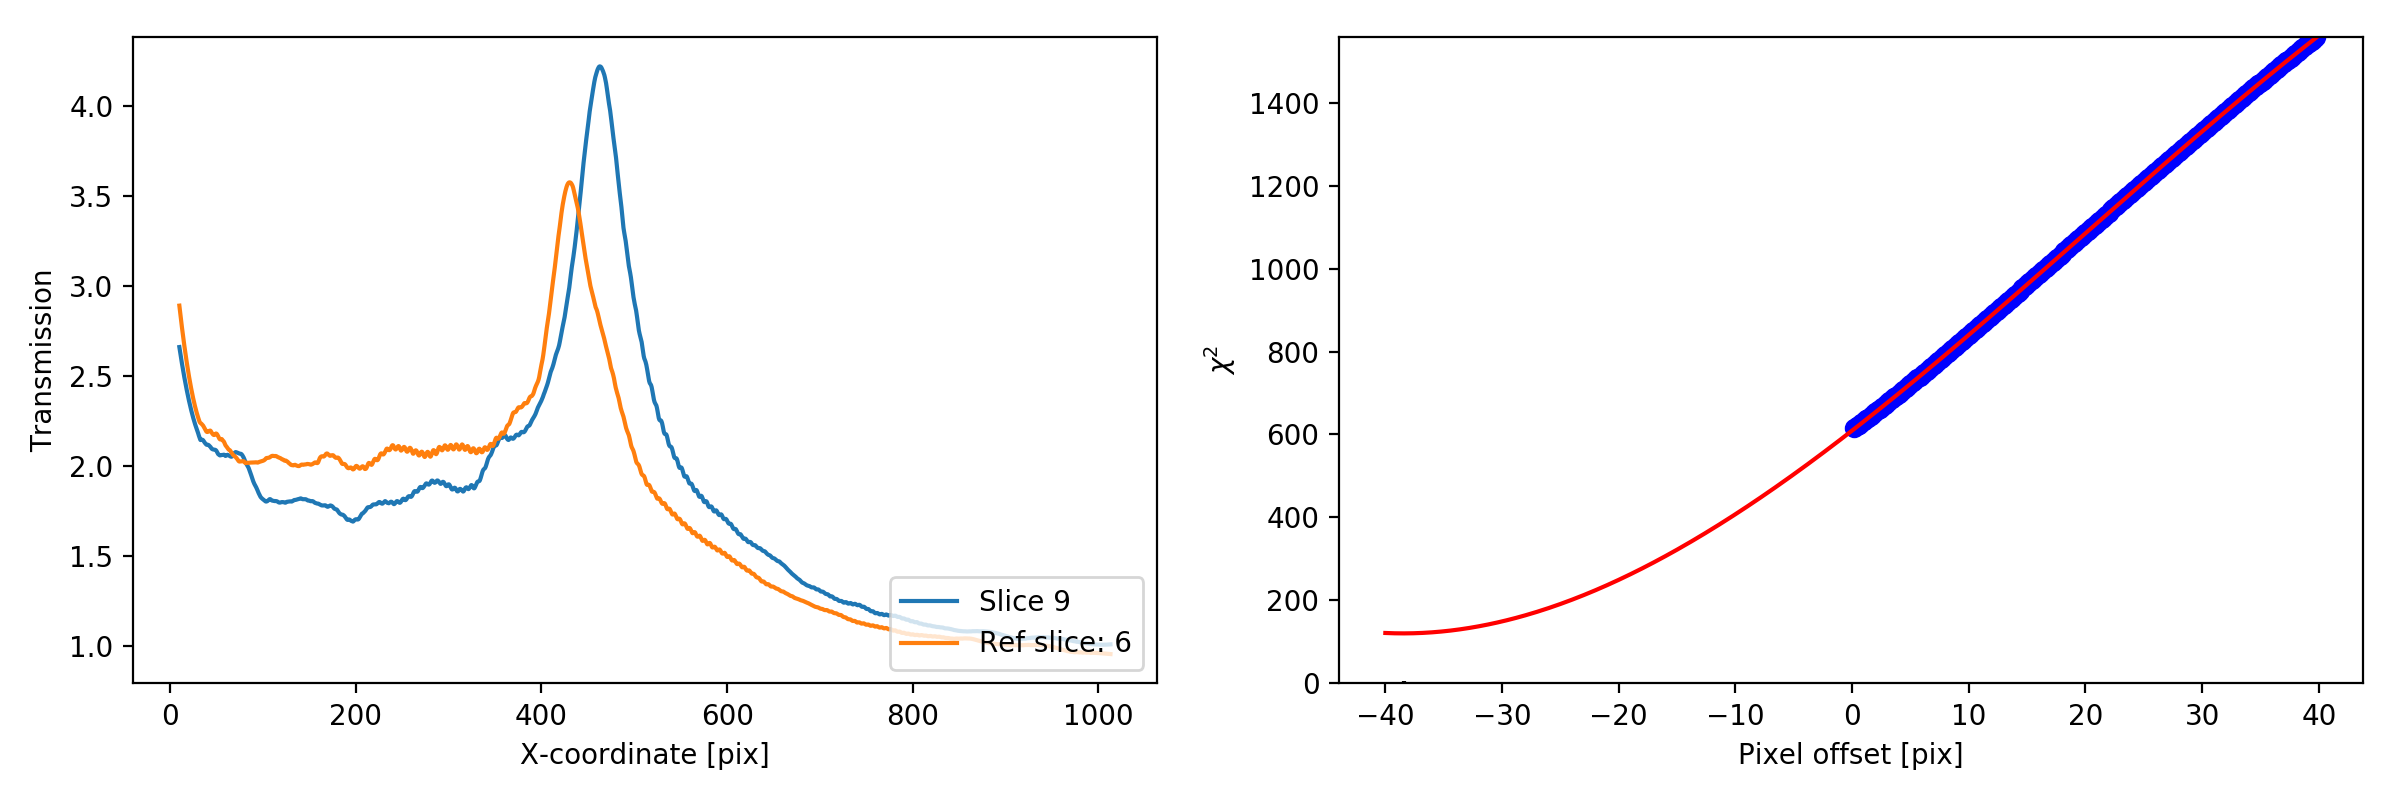

Slice 9
Pixel offset: -38.4pix


<IPython.core.display.Javascript object>


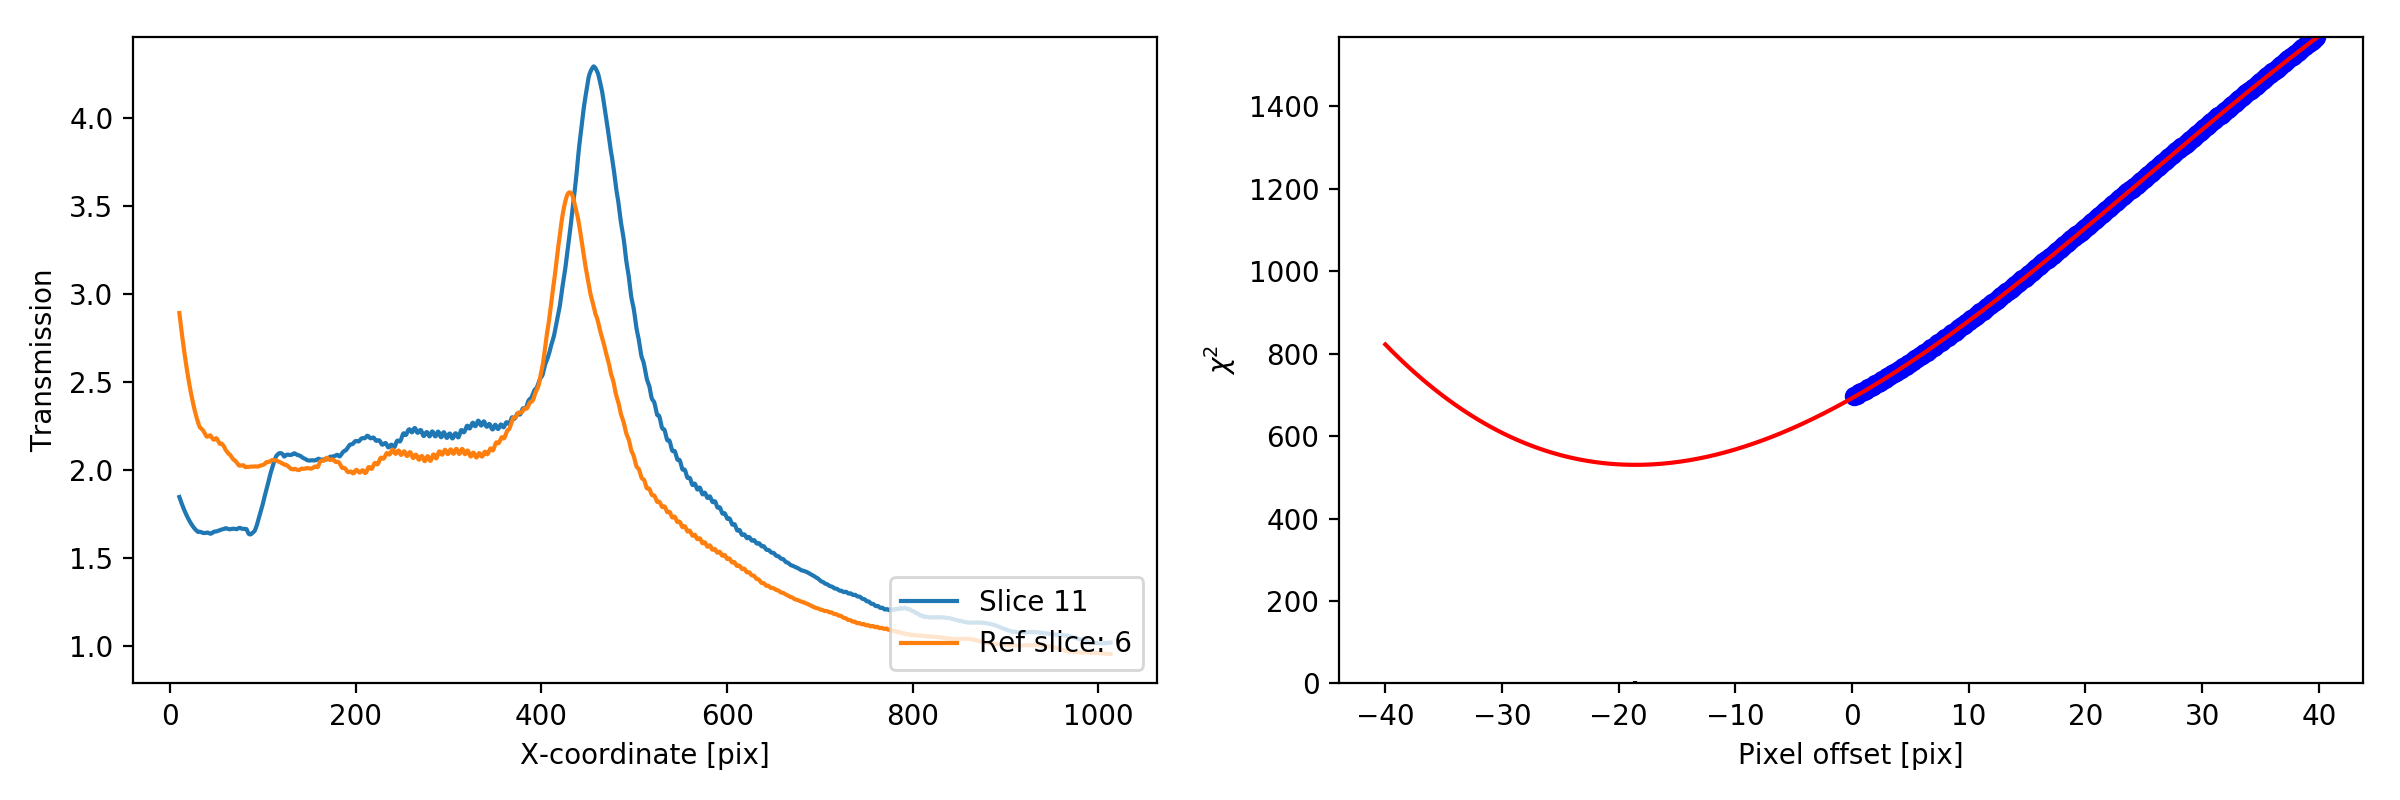

Slice 11
Pixel offset: -18.6pix


<IPython.core.display.Javascript object>


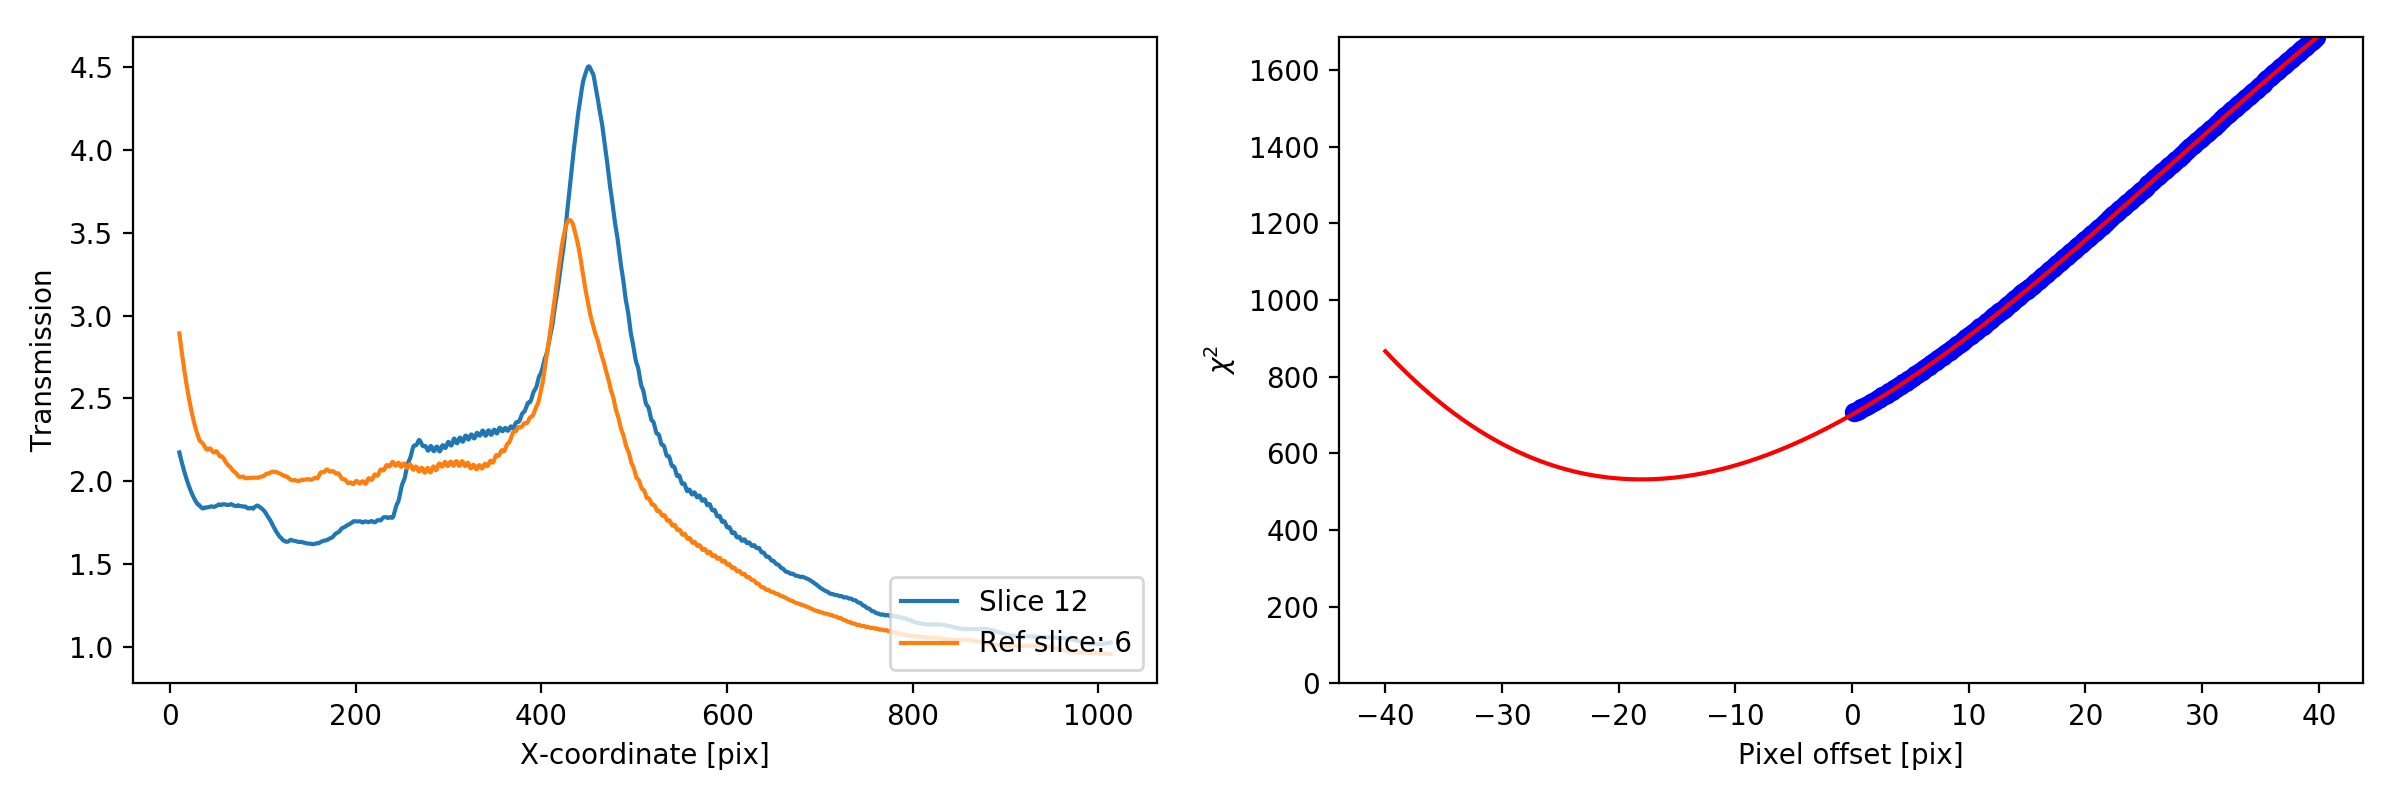

Slice 12
Pixel offset: -18.0pix


In [9]:
plt.close('all')
# reference spectral trace
lower,upper = 10,-10
ypos_ref,xpos_ref = funcs.detpixel_trace(band,d2cMaps,sliceID=ref_slice,alpha_pos=ref_alpha)
sci_fm_data_ref = mrs_transmission_img[ypos_ref,xpos_ref][lower:upper]

# create a finer grid
step = 0.2
fine_grid = np.arange(lower,1023-abs(upper)+step,step)
if band == '2C': fine_grid = fine_grid[:-2]
sci_fm_data_ref_fine = interp1d(lower+np.arange(len(sci_fm_data_ref)),sci_fm_data_ref)(fine_grid)
sci_fm_data_ref_fine = savgol_filter(sci_fm_data_ref_fine,201,2)

pix_offsets = []
offsets = np.arange(1,200)
wider_offsets = np.arange(-200,200)
if band == '2C':
    offsets = np.arange(1,300)
    wider_offsets = np.arange(-200,300)
plot = True
for islice in range(1,nslices+1):
# for islice in [3]:
    if islice == 10:
        pix_offset = 0.
        pix_offsets.append(round(pix_offset,2))
        continue
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=ref_alpha)
    
    if band in ['1B','1C','2A','2B','2C','4C']:
        sci_fm_data = mrs_transmission_img[ypos,xpos][lower:upper]

        sci_fm_data_fine = interp1d(lower+np.arange(len(sci_fm_data)),sci_fm_data)(fine_grid)
        sci_fm_data_fine = savgol_filter(sci_fm_data_fine,201,2)

        # polynomial fit order
        if band in ['1B','1C']: order = 2
        elif band in ['2A','2B','2C','4C']: order = 3
        if ((lambdaMap[ypos_ref,xpos_ref][len(ypos)/2] - lambdaMap[ypos,xpos][len(ypos)/2]) > 0.) & (band not in ['4A']) :
            residuals = []
            for offset in offsets:
                residuals.append(np.sum(((sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])[~np.isnan(sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])])[:-300]**2))
            residuals = np.array(residuals)


            popt     = np.polyfit(offsets,residuals,order)
            poly     = np.poly1d(popt)

            if band in ['1B','1C']: pix_offset = -popt[1]/(2.*popt[0])*step
            elif band in ['2A','2B','2C','4C']: pix_offset = wider_offsets[np.argmin(poly(wider_offsets))]*step

            if plot is True:
                fig,axs = plt.subplots(1,3,figsize=(12,4))
                axs[0].plot(fine_grid,sci_fm_data_fine,label='Slice {}'.format(islice))
                axs[0].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
                axs[1].plot(offsets*step,residuals,'bo')
                axs[1].plot(wider_offsets*step,poly(wider_offsets),'r')
                axs[1].vlines(pix_offset,-3,5,'k',linestyle='dashed')
                axs[1].set_ylim(0,max(residuals))
                axs[2].plot(fine_grid[:len(sci_fm_data_fine[np.argmin(poly(offsets)):])],sci_fm_data_fine[np.argmin(poly(offsets)):],label='Slice {}'.format(islice))
                axs[2].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
                for iplot in [0,2]:
                    axs[iplot].set_xlabel('X-coordinate [pix]')
                    axs[iplot].set_ylabel('Transmission')
                    axs[iplot].legend(loc='lower right')
                axs[1].set_xlabel('Pixel offset [pix]')
                axs[1].set_ylabel(r'$\chi$$^2$')
                plt.tight_layout()
        elif ((lambdaMap[ypos_ref,xpos_ref][len(ypos)/2] - lambdaMap[ypos,xpos][len(ypos)/2]) < 0.) or (band in ['4A']) :
            residuals = []
            for offset in offsets:
                residuals.append(np.sum(((sci_fm_data_ref_fine[offset:]-sci_fm_data_fine[:-offset])[~np.isnan(sci_fm_data_ref_fine[offset:]-sci_fm_data_fine[:-offset])])[:-300]**2))
            residuals = np.array(residuals)

            popt     = np.polyfit(offsets,residuals,order)
            poly     = np.poly1d(popt)

            if band in ['1B','1C']: pix_offset = -popt[1]/(2.*popt[0])*step
            elif band in ['2A','2B','2C','4C']: pix_offset = wider_offsets[np.argmin(poly(wider_offsets))]*step

            if plot is True:
                fig,axs = plt.subplots(1,2,figsize=(12,4))
                axs[0].plot(fine_grid,sci_fm_data_fine,label='Slice {}'.format(islice))
                axs[0].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
                axs[1].plot(offsets*step,residuals,'bo')
                axs[1].plot(wider_offsets*step,poly(wider_offsets),'r')
                axs[1].vlines(pix_offset,-3,5,'k',linestyle='dashed')
                axs[1].set_ylim(0,max(residuals))
    #             axs[2].plot(fine_grid[:len(sci_fm_data_ref_fine[np.argmin(poly(wider_offsets)):])],sci_fm_data_ref_fine[np.argmin(poly(wider_offsets)):],label='Slice {}'.format(islice))
    #             axs[2].plot(fine_grid,sci_fm_data_fine,label='Ref slice: {}'.format(ref_slice))
                for iplot in [0]:
                    axs[iplot].set_xlabel('X-coordinate [pix]')
                    axs[iplot].set_ylabel('Transmission')
                    axs[iplot].legend(loc='lower right')
                axs[1].set_xlabel('Pixel offset [pix]')
                axs[1].set_ylabel(r'$\chi$$^2$')
                plt.tight_layout()
            
    if band in ['4A','4B']:
        # load reference point
        refpoint_file   = 'data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_refpoint_'+user+'.txt'
        ref_cutoffpix = np.loadtxt(refpoint_file,unpack=True,usecols=(0,1), skiprows = 5)[1]
        # load spectrum from desired location and carry-out analysis
        mrs_transmission = np.flipud(mrs_transmission_img[ypos,xpos])
        # determine cut-off wavelength/pixel pair
        usedfilter,filter_wave,filter_transm = funcs.filter_transmission(band,datapath=FilterTransmDir)
        cutofflamb,cutoffpix = funcs.get_reference_point(band,filter_wave,filter_transm,mrs_transmission)
        
        # save offset
        pix_offset = len(mrs_transmission)-cutoffpix-ref_cutoffpix
        
    pix_offsets.append(round(pix_offset,2))
    print 'Slice {}'.format(islice)
    print 'Pixel offset: {}pix'.format(pix_offsets[islice-1])

In [10]:
# save output
save_file = open('data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_reloffsets.txt', 'w')
save_file.write('# Band '+str(band)+'   Filter {}   RefSlice '.format(usedfilter)+str(ref_slice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'\n')
save_file.write('\n')
save_file.write('# Slice Nr.  Pixel offset (pix)\n')

for zzz in range(1,nslices+1):
    save_file.write(str(zzz)+'  '+str(pix_offsets[zzz-1])+'\n')
save_file.close()